For this chapter we'll be participating in a real kaggle competition and evaluate each of the regularization techniques of the chapter 7                                                                                                               
https://www.kaggle.com/c/rsna-str-pulmonary-embolism-detection/overview                                                       
dataset from                                                                                                                  
https://www.kaggle.com/c/rsna-str-pulmonary-embolism-detection/discussion/182930

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
import os
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

# import cv2
import glob

from tqdm import tqdm

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device
    
device

device(type='cuda')

In [3]:
train_path = 'D:\\lungs\\train-jpegs'
csv_path = 'E:\\Download\\new_downloads\\train.csv'

In [4]:
df_train = pd.read_csv(csv_path)

In [5]:
df_train.shape

(1790594, 17)

In [6]:
df_train.head()

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
0,6897fa9de148,2bfbb7fd2e8b,c0f3cb036d06,0,0,0,0,0,0,1,1,0,0,1,0,0,0
1,6897fa9de148,2bfbb7fd2e8b,f57ffd3883b6,0,0,0,0,0,0,1,1,0,0,1,0,0,0
2,6897fa9de148,2bfbb7fd2e8b,41220fda34a3,0,0,0,0,0,0,1,1,0,0,1,0,0,0
3,6897fa9de148,2bfbb7fd2e8b,13b685b4b14f,0,0,0,0,0,0,1,1,0,0,1,0,0,0
4,6897fa9de148,2bfbb7fd2e8b,be0b7524ffb4,0,0,0,0,0,0,1,1,0,0,1,0,0,0


In [7]:
df_train.tail()

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
1790589,4833c9b6a5d0,57e3e3c5f910,da0ecef50cf5,0,0,0,0,0,0,1,1,1,0,0,0,0,0
1790590,4833c9b6a5d0,57e3e3c5f910,d74b46c2f2c4,0,0,0,0,0,0,1,1,1,0,0,0,0,0
1790591,4833c9b6a5d0,57e3e3c5f910,ba71189191ad,0,0,0,0,0,0,1,1,1,0,0,0,0,0
1790592,4833c9b6a5d0,57e3e3c5f910,f4fdc88f2ace,0,0,0,0,0,0,1,1,1,0,0,0,0,0
1790593,4833c9b6a5d0,57e3e3c5f910,f890efd48940,1,0,0,0,0,0,1,1,1,0,0,0,0,0


In [8]:
image_level_features = ['pe_present_on_image']
# exam_level_features = ['negative_exam_for_pe', 
exam_level_features = ['indeterminate', 'chronic_pe', 'acute_and_chronic_pe', 'central_pe', 'leftsided_pe', 'rightsided_pe', 'rv_lv_ratio_gte_1', 'rv_lv_ratio_lt_1',]
informational_features = ['qa_motion', 'qa_contrast', 'true_filling_defect_not_pe', 'flow_artifact']

In [9]:
df_train.loc[df_train['pe_present_on_image'] == 0, exam_level_features] = 0
df_train[df_train.pe_present_on_image == 1].shape[0], df_train[df_train.pe_present_on_image == 0].shape[0], df_train[df_train.pe_present_on_image == 1].shape[0]/df_train[df_train.pe_present_on_image == 0].shape[0] # high inbalance

train_df_0 = df_train[df_train.pe_present_on_image == 0].sample(int(df_train[df_train.pe_present_on_image == 1].shape[0]*2.5), replace=False)
train_df_1 = df_train[df_train.pe_present_on_image == 1].sample(int(df_train[df_train.pe_present_on_image == 1].shape[0]*0.8), replace=False)

In [10]:
train_df = train_df_0.append(train_df_1, ignore_index=False)

In [11]:
train_df

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
1333943,433de9f48203,8f372621c614,b3af5e034aba,0,0,0,0,0,0,0,0,0,0,0,0,0,0
803744,f693fb899369,3e18ab3b91ac,35d5e93de0d7,0,1,0,0,0,0,0,0,0,0,0,0,0,0
708940,1ebe0342c44e,48860ba70bc7,5f77c241b69c,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1676607,aa4e349261e0,e1f81b4e4c5e,40aed1c23a50,0,1,0,0,0,0,0,0,0,0,0,0,0,0
54562,610f15a869cc,8d823b75bc75,483085d87f9e,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1569543,8660c476ad4e,ba8afd325db5,24c804425862,1,0,0,0,0,0,1,1,0,0,1,0,0,0
720165,c751765f02b3,23225ef05c04,70cba66506da,1,0,0,0,0,0,1,0,0,0,1,0,0,0
1752240,635fab5c507c,434f1059e22d,432a342467eb,1,0,0,0,0,0,1,1,0,0,0,0,0,0
1451386,eb835e5ea3f3,f59e4946fb15,b00817eb5e0b,1,0,0,0,0,0,1,0,0,0,1,0,0,0


In [12]:
df_train = df_train.drop(train_df.index)

In [13]:
# df_train[df_train.pe_present_on_image==1]
val_df = df_train[df_train.pe_present_on_image==1].append(df_train[df_train.pe_present_on_image==0].sample(int(df_train[df_train.pe_present_on_image == 1].shape[0]*2.5), replace=False))

In [14]:
val_df = val_df.sample(frac=1).reset_index(drop=True)
train_df = train_df.sample(frac=1).reset_index(drop=True)

In [15]:
del df_train

In [16]:
train_df

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
0,17527137e960,65828cbcca03,f1043e9db259,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,e5e7bf8fe26b,281c3a21a9ef,51c7c796add1,1,0,0,0,0,0,1,0,0,0,1,0,0,0
2,09d647cd2156,a94ccf027860,e0198d43beba,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,6bfa97b0bf32,4543454fb9d2,8d8d7e043cd2,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,8ce178f474d1,92b51b226d59,0816f6a5e7af,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318577,321c0f0a6883,9bc4119d72db,2d2c56433c46,0,1,0,0,0,0,0,0,0,1,0,0,0,0
318578,756cd5f4d4c5,b8a797a4182c,fee7608430c1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
318579,6828d79b1dce,211d40c9b233,4e7d85fb3b8a,0,0,0,0,0,0,0,0,0,0,0,0,0,0
318580,8d1b2c8e3857,f4bc2cc32b08,f03304105add,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
val_df

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
0,70e2fd3fe944,312092d970e9,598030616ec9,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,dccd8ad83683,a9ffa303d883,2aa471c37162,1,0,0,0,0,0,1,1,0,0,1,0,0,0
2,7f96aa038d4e,f1bf75321831,cd8bf1db329a,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,4b082e5875c9,3a20e42aef67,58523022a48a,0,1,0,0,1,0,0,0,0,0,0,0,0,0
4,4f54cd07d3ff,54d2daf3b590,ef3df64d4803,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67573,43b651dbc5e1,5b68c7557058,a4bb0c6da3b4,0,0,0,0,0,0,0,0,0,0,0,0,0,0
67574,08f99ee20545,1963acd90679,94a7327ccc1e,1,0,0,0,0,1,0,1,0,0,1,0,1,0
67575,eadb583fdf52,16703636e9fe,7b68947a9bde,1,0,0,0,0,0,1,0,0,0,1,0,0,0
67576,a958a774a74e,0fa117cabe47,ad1420136924,1,0,0,0,0,0,1,0,0,0,1,0,0,0


In [18]:
def get_an_image(df, idx=0):
    row = df.iloc[idx]
    img = Image.open(glob.glob(f"{train_path}/{row[0]}/{row[1]}/*{row[2]}.jpg")[0])
    return img

In [19]:
img = get_an_image(train_df, 0)

In [20]:
np.array(img).shape

(256, 256, 3)

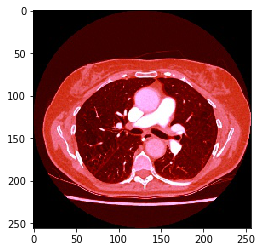

In [21]:
plt.imshow(img)

In [22]:
def plot_image(img):
    plt.figure(figsize=[12,6])
    plt.subplot(131)
    plt.imshow(img[:,:,0],cmap='gray')
    plt.subplot(132)
    plt.imshow(img[:,:,1],cmap='gray')
    plt.subplot(133)
    plt.imshow(img[:,:,2],cmap='gray')

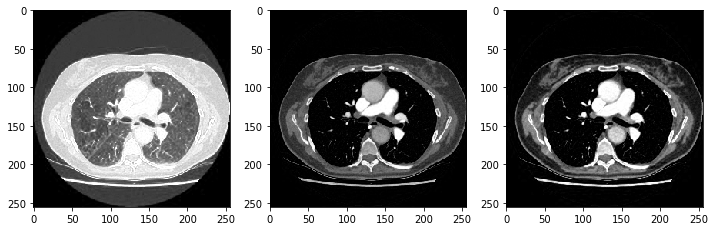

In [23]:
plot_image(np.array(img))

In [24]:
class LungsDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        self.csv_file = csv_file
        self.transform = transform

    def __len__(self):
        return len(self.csv_file)

    def __getitem__(self, idx):

        row = self.csv_file.iloc[idx]
        img = Image.open(glob.glob(f"{train_path}/{row[0]}/{row[1]}/*{row[2]}.jpg")[0])

        img = self.transform(img).to(device)
        targets = torch.tensor(row[image_level_features+exam_level_features + informational_features].values.astype(np.float16)).float().to(device)

        return img, targets

In [25]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

ds_trans = transforms.Compose([
                                transforms.Grayscale(num_output_channels=3),
                                transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                
#                                 transforms.CenterCrop(224),
                                normalize
])

invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

In [26]:
train_dataset = LungsDataset(train_df, transform=ds_trans)

val_dataset = LungsDataset(val_df, transform=ds_trans)

len(train_dataset), len(val_dataset)

(318582, 67578)

In [27]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

In [28]:
# xx = 0
# yy = 0
# for i, x in enumerate(train_dataloader):
# #     print('AAAAAAAAA', x[0].shape, x[1].shape)
# #     print(x[0])
    
#     print('---'*40)
#     if i == 0:
#         xx = x[0]
#     if i == 1:
#         yy = x[1]
#         break
# #     print(x[1])

In [29]:
# plot_image(xx[3].cpu().permute(1,2,0))

In [30]:
resnet101 = models.resnet50()
fc_feat_size = resnet101.fc.in_features
resnet101.fc.in_features, resnet101.fc.out_features

(2048, 1000)

In [31]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
    def __forward__(self, x):
        x = x.view(x.size(0), -1)
        return x
    
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

In [32]:
resnet101.avgpool = Identity()
resnet101.fc = Identity()

In [33]:
resnet101

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [34]:
fc_feat_size

2048

In [35]:
# fc_feat_size = 1024
def weights_init(m):
    classname = m.__class__.__name__
    for l in m.modules():
        if isinstance(l, nn.Conv2d):
            torch.nn.init.uniform_(l.weight)
        elif isinstance(l, nn.BatchNorm2d):
            torch.nn.init.uniform_(l.weight)
        elif isinstance(l, nn.Linear):
            torch.nn.init.xavier_normal_(l.weight)
        
class MultiTaskHead(nn.Module):
    def __init__(self):
        super(MultiTaskHead, self).__init__()
        self.m = nn.Sequential(
                nn.Conv2d(2048, 512, kernel_size=(1,1), stride=(1,1), bias=False), 
                nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
                nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                nn.Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False),
                nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                nn.AdaptiveAvgPool2d(output_size=(1,1)),
        )
        self.l = nn.Sequential(
                nn.Linear(fc_feat_size, 1, bias=True), 
#                 nn.ReLU(),
#                 nn.Linear(512, 1), 
                nn.Sigmoid()
        )
        
    def forward(self, x):
        x = x.view(x.shape[0], 2048, int(np.sqrt(x.shape[1]/2048)), int(np.sqrt(x.shape[1]/2048)))
        x = self.m(x)
        x = self.l(x.squeeze())
        return x

class WrapperModel(nn.Module):
    def __init__(self, pretrained_model):
        super(WrapperModel, self).__init__()
        self.stage = 'train'
        
        self.backbone = pretrained_model
        '''
        image-level feature
        '''
        self.linear_pe_present_on_image = MultiTaskHead()
        weights_init(self.linear_pe_present_on_image)
        '''
        exam-level features
        '''
        self.linear_negative_exam_for_pe = MultiTaskHead()
        weights_init(self.linear_negative_exam_for_pe)
        
        self.linear_indeterminate = MultiTaskHead()
        weights_init(self.linear_indeterminate)
        
        self.linear_chronic_pe = MultiTaskHead()
        weights_init(self.linear_chronic_pe)
        
        self.linear_acute_and_chronic_pe = MultiTaskHead()
        weights_init(self.linear_acute_and_chronic_pe)
        
        self.linear_central_pe = MultiTaskHead()
        weights_init(self.linear_central_pe)
        
        self.linear_leftsided_pe = MultiTaskHead()
        weights_init(self.linear_leftsided_pe)
        
        self.linear_rightsided_pe = MultiTaskHead()
        weights_init(self.linear_rightsided_pe)
        
        self.linear_rv_lv_ratio_gte_1 = MultiTaskHead()
        weights_init(self.linear_rv_lv_ratio_gte_1)
        
        self.linear_rv_lv_ratio_lt_1 = MultiTaskHead()
        weights_init(self.linear_rv_lv_ratio_lt_1)
        
        '''
        informational features
        '''
        self.linear_qa_motion = MultiTaskHead()
        weights_init(self.linear_qa_motion)
        
        self.linear_qa_contrast = MultiTaskHead()
        weights_init(self.linear_qa_contrast)
                
        self.linear_true_filling_defect_not_pe = MultiTaskHead()
        weights_init(self.linear_true_filling_defect_not_pe)
        
        self.linear_flow_artifact = MultiTaskHead()
        weights_init(self.linear_flow_artifact)

    def forward(self, x):
#         if self.stage == 'train':
#             x, _ = self.backbone(x)
#         else: 
        x = self.backbone(x)
        
#         print('x1 .shape', x1.shape)
        x_pe_present_on_image = self.linear_pe_present_on_image(x)
        
        x_negative_exam_for_pe = self.linear_negative_exam_for_pe(x)
        x_indeterminate = self.linear_indeterminate(x)
        x_chronic_pe = self.linear_chronic_pe(x)
        x_acute_and_chronic_pe = self.linear_acute_and_chronic_pe(x)
        x_central_pe = self.linear_central_pe(x)
        x_leftsided_pe = self.linear_leftsided_pe(x)
        x_rightsided_pe = self.linear_rightsided_pe(x)
        x_rv_lv_ratio_gte_1 = self.linear_rv_lv_ratio_gte_1(x)
        x_rv_lv_ratio_lt_1 = self.linear_rv_lv_ratio_lt_1(x)
        
        x_qa_motion = self.linear_qa_motion(x)
        x_qa_contrast = self.linear_qa_contrast(x)
        x_true_filling_defect_not_pe = self.linear_true_filling_defect_not_pe(x)
        x_flow_artifact = self.linear_flow_artifact(x)
        
#         ys = []
#         for y_pred in [ x_pe_present_on_image, x_negative_exam_for_pe, x_indeterminate, x_chronic_pe, x_acute_and_chronic_pe, x_central_pe, x_leftsided_pe, x_rightsided_pe, x_rv_lv_ratio_gte_1, x_rv_lv_ratio_lt_1, x_qa_motion, x_qa_contrast, x_true_filling_defect_not_pe, x_flow_artifact]:
#             ys.append(y_pred)
        ys = []
        for y_pred in [ x_pe_present_on_image, x_indeterminate, x_chronic_pe, x_acute_and_chronic_pe, x_central_pe, x_leftsided_pe, x_rightsided_pe, x_rv_lv_ratio_gte_1, x_rv_lv_ratio_lt_1, x_qa_motion, x_qa_contrast, x_true_filling_defect_not_pe, x_flow_artifact]:
            ys.append(y_pred)
        return torch.cat(ys, 1)
                      

model = WrapperModel(resnet101).to(device)

In [36]:
model

WrapperModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

In [37]:
# df_train.loc[0][image_level_features+exam_level_features+informational_features]

In [38]:
for name, param in model.named_parameters():
#     if not (name.startswith('backbone.layer3') or name.startswith('backbone.layer4') or name.startswith('backbone.Mixed_') or name.startswith('linear')):
    if not (name.startswith('backbone.layer3') or name.startswith('backbone.layer4') or name.startswith('linear')):
        param.requires_grad = False
    else:
        param.requires_grad = True

In [39]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

backbone.conv1.weight False
backbone.bn1.weight False
backbone.bn1.bias False
backbone.layer1.0.conv1.weight False
backbone.layer1.0.bn1.weight False
backbone.layer1.0.bn1.bias False
backbone.layer1.0.conv2.weight False
backbone.layer1.0.bn2.weight False
backbone.layer1.0.bn2.bias False
backbone.layer1.0.conv3.weight False
backbone.layer1.0.bn3.weight False
backbone.layer1.0.bn3.bias False
backbone.layer1.0.downsample.0.weight False
backbone.layer1.0.downsample.1.weight False
backbone.layer1.0.downsample.1.bias False
backbone.layer1.1.conv1.weight False
backbone.layer1.1.bn1.weight False
backbone.layer1.1.bn1.bias False
backbone.layer1.1.conv2.weight False
backbone.layer1.1.bn2.weight False
backbone.layer1.1.bn2.bias False
backbone.layer1.1.conv3.weight False
backbone.layer1.1.bn3.weight False
backbone.layer1.1.bn3.bias False
backbone.layer1.2.conv1.weight False
backbone.layer1.2.bn1.weight False
backbone.layer1.2.bn1.bias False
backbone.layer1.2.conv2.weight False
backbone.layer1.2.bn

In [ ]:
# df_train.head()

In [ ]:
# '''
# Weights
# '''
# image_level_weights = [0.07361963]
# exam_level_weights = [0.0736196319, 0.09202453988, 0.1042944785, 0.1042944785, 0.1877300613, 0.06257668712, 0.06257668712, 0.2346625767, 0.0782208589]

# # Negative for PE	0.0736196319
# # Indeterminate	0.09202453988
# # Chronic	0.1042944785
# # Acute & Chronic	0.1042944785
# # Central PE	0.1877300613
# # Left PE	0.06257668712
# # Right PE	0.06257668712
# # RV/LV Ratio >= 1	0.2346625767
# # RV/LV Ratio < 1	0.0782208589



In [ ]:
# model.load_state_dict(torch.load('./saved_resnet50'))
# # model.eval()

In [40]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, )

In [90]:
def compute_accuracy(y_pred, y_true, threshold=0.5):
    '''
    computes accuracy, precision and recall
    '''
    return ((y_pred >= threshold)==y_true).sum().item()/(y_pred.shape[0]*y_true.shape[1]), ((y_pred >= threshold)*y_true).sum().item()/y_true.sum().item(), ((y_pred >= threshold)*y_true).sum().item()/y_pred.sum().item()

In [42]:
def evaluate_on(model, dataloader, stage):
    print('Evaluating on', stage)
    
    running_loss = []
    running_accuracy = []
    running_precision = []
    running_recall = []
    
    model.eval()
    with torch.no_grad():
        for x,y in tqdm(dataloader, total=len(dataloader)):
            total_loss = 0
            y_pred = model(x)
            for i in range(y.shape[1]):
                loss_i = criterion(y_pred[:,i], y[:,i])
                total_loss += loss_i
            running_loss.append(total_loss.item())
            accur, prec, rec = compute_accuracy(y_pred, y)
            running_accuracy.append(accur)
            running_precision.append(prec)
            running_recall.append(rec)
            
    return np.array(running_loss).mean(), np.array(running_accuracy).mean(), np.array(running_precision).mean(), np.array(running_recall).mean()

In [43]:
torch.autograd.set_detect_anomaly(True)

epochs = 100

running_losses = []
train_losses = []
train_accuracies = []
val_losses = []
val_precisions = []
val_recalls = []
val_accuracies = []

val_loss, val_accuracy, val_prec, val_rec = evaluate_on(model, val_dataloader, 'validation')
val_losses.append(val_loss)
val_accuracies.append(val_accuracy)
val_precisions.append(val_prec)
val_recalls.append(val_rec)

print('val_loss, val_accuracy', val_loss, val_accuracy)
print('val_prec, val_rec', val_prec, val_rec)

model.train()
for epoch in range(epochs):  
    print('Epoch Number:', epoch)
    running_loss = 0.0
    for j, (x,y) in enumerate(train_dataloader):

        optimizer.zero_grad()
        
        y_pred = model(x)
        total_loss = 0

        for i in range(y.shape[1]):
            loss_i = criterion(y_pred[:,i], y[:,i])
            total_loss += loss_i
        total_loss.backward()
        optimizer.step()
        
        running_loss += total_loss.item()
        
        if j % 10 == 0: 
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 50))
        
            val_loss, val_accuracy, val_prec, val_rec = evaluate_on(model, val_dataloader, 'validation')
            print('val_loss, val_accuracy', val_loss, val_accuracy)
            print('val_prec, val_rec', val_prec, val_rec)
#             train_loss, train_accuracy = evaluate_on(model, train_dataloader, 'train')
#             print('train_loss, train_accuracy', train_loss, train_accuracy)
            
            running_losses.append(running_loss)
#             train_losses.append(train_loss)
            val_losses.append(val_loss)
            
#             train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)
            val_precisions.append(val_prec)
            val_recalls.append(val_rec)
            if val_loss < min(val_losses):
                torch.save(model.state_dict(), ('E:/Download/new_downloads/checkpoints/resnet_'+str(val_loss)+'_'+str(val_accuracy)+'_'+'_'+str(val_prec)+'_'+str(val_rec)).replace('.','_'))
            
            model.train()
            running_loss = 0.0
            
print('Finished Training')

  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [10:25<00:00,  1.69it/s]


val_loss, val_accuracy 513.8243289138331 0.6047505161863999
val_prec, val_rec 0.4463953704896459 0.11517896502742948
Epoch Number: 0


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.182
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:12<00:00,  2.84it/s]


val_loss, val_accuracy 239.2241045778448 0.6169581754003898
val_prec, val_rec 0.5068509178840589 0.1225473803189641


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 1.762
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:13<00:00,  2.83it/s]


val_loss, val_accuracy 7.87320487517299 0.7480361603644201
val_prec, val_rec 0.005733664029419181 0.0016241781158336682


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 1.693
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:14<00:00,  2.82it/s]


val_loss, val_accuracy 7.884800625569893 0.900763164637087
val_prec, val_rec 0.0 0.0


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 1.631
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:13<00:00,  2.83it/s]


val_loss, val_accuracy 7.77875176523671 0.7544649809601317
val_prec, val_rec 0.03955423460829666 0.012215336926989163


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 1.580
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:13<00:00,  2.83it/s]


val_loss, val_accuracy 6.958518161918178 0.8947141445120971
val_prec, val_rec 0.06930040486583361 0.019146317382857794


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 1.534
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:14<00:00,  2.82it/s]


val_loss, val_accuracy 7.203244874874751 0.889306825089422
val_prec, val_rec 0.22127854861057336 0.05430353663860777


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 1.471
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:13<00:00,  2.82it/s]


val_loss, val_accuracy 6.907178750995434 0.899282504044088
val_prec, val_rec 0.18296601492336967 0.04631180026789518


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 1.407
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:14<00:00,  2.82it/s]


val_loss, val_accuracy 6.544903408397328 0.9014590272335423
val_prec, val_rec 0.053272960261844846 0.014729969571159057


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 1.364
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:14<00:00,  2.82it/s]


val_loss, val_accuracy 7.168701153812987 0.8482784445708746
val_prec, val_rec 0.7113825431735701 0.16417656615474926


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 1.319
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:13<00:00,  2.83it/s]


val_loss, val_accuracy 6.915443541425647 0.8548783853538703
val_prec, val_rec 0.6926986945169741 0.1645581307399456


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 1.252
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:13<00:00,  2.83it/s]


val_loss, val_accuracy 6.142354079268196 0.8910277604041074
val_prec, val_rec 0.38038131712046497 0.10431789928720722


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 1.206
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:13<00:00,  2.82it/s]


val_loss, val_accuracy 6.4864706103548855 0.862471961407845
val_prec, val_rec 0.6735622746437002 0.1693370631807313


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 1.158
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:13<00:00,  2.83it/s]


val_loss, val_accuracy 6.0913577156536505 0.8753911823180411
val_prec, val_rec 0.593456536179145 0.15894244204960323


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 1.122
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:12<00:00,  2.83it/s]


val_loss, val_accuracy 5.587288907531536 0.8911291765884978
val_prec, val_rec 0.445257727930444 0.13221564828882265


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 1.078
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:13<00:00,  2.83it/s]


val_loss, val_accuracy 5.166096997983528 0.9010155276655815
val_prec, val_rec 0.006413032533212139 0.002376479795639426


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 1.027
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:12<00:00,  2.84it/s]


val_loss, val_accuracy 6.1237413056872105 0.8469021829912186
val_prec, val_rec 0.713341302010558 0.19248432161587095


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.989
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:13<00:00,  2.83it/s]


val_loss, val_accuracy 5.00393935676777 0.9007784712593441
val_prec, val_rec 0.0005062172200741709 0.00019973368415020012


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.954
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:13<00:00,  2.83it/s]


val_loss, val_accuracy 7.201590822953166 0.7929735382254239
val_prec, val_rec 0.8644857828153666 0.2163509434092164


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.912
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:13<00:00,  2.82it/s]


val_loss, val_accuracy 4.611877617059332 0.9033840508449884
val_prec, val_rec 0.2764479985715844 0.1036368177694191


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.864
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:13<00:00,  2.82it/s]


val_loss, val_accuracy 4.542916413509484 0.9001152235426212
val_prec, val_rec 0.3622083538885973 0.13593310096531117


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.858
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:13<00:00,  2.83it/s]


val_loss, val_accuracy 4.917605927496245 0.871179938057632
val_prec, val_rec 0.6307420070960014 0.2114159297902584


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.823
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:14<00:00,  2.82it/s]


val_loss, val_accuracy 4.3061747801574795 0.9007642243263202
val_prec, val_rec 0.0 0.0


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.801
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:13<00:00,  2.83it/s]


val_loss, val_accuracy 4.483926377513192 0.886496411499779
val_prec, val_rec 0.5498337480666968 0.20311187987745255


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.758
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:13<00:00,  2.83it/s]


val_loss, val_accuracy 3.899641291661696 0.9044172478473395
val_prec, val_rec 0.17295145054678052 0.0828772020489996


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.757
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:14<00:00,  2.82it/s]


val_loss, val_accuracy 3.8266611297925315 0.9017699871518569
val_prec, val_rec 0.026163420491812566 0.015743510740602217


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.717
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:13<00:00,  2.83it/s]


val_loss, val_accuracy 4.210702928629789 0.882154864711438
val_prec, val_rec 0.6089593602732629 0.24091674322161089


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.689
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:13<00:00,  2.83it/s]


val_loss, val_accuracy 3.664009892353506 0.9033229813469578
val_prec, val_rec 0.06857316358863197 0.03884966580698663


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.692
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:14<00:00,  2.82it/s]


val_loss, val_accuracy 4.1904940169417495 0.878308153547243
val_prec, val_rec 0.596346506815608 0.24041297084774477


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.684
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:13<00:00,  2.83it/s]


val_loss, val_accuracy 3.546324536430113 0.9009612872759424
val_prec, val_rec 0.004431491913517991 0.0033042951846217004


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.688
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:13<00:00,  2.82it/s]


val_loss, val_accuracy 3.4666808024048805 0.9010005350253196
val_prec, val_rec 0.004494696419321836 0.0031340228163099187


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.655
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:14<00:00,  2.82it/s]


val_loss, val_accuracy 3.418643539376331 0.901067923411
val_prec, val_rec 0.005686313310773114 0.004205688313723721


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.645
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:15<00:00,  2.81it/s]


val_loss, val_accuracy 3.2900912445602994 0.9041625692016317
val_prec, val_rec 0.10039340023473185 0.07203873978714707


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.612
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:14<00:00,  2.82it/s]


val_loss, val_accuracy 3.59812762475375 0.8906441921494455
val_prec, val_rec 0.5252156326821608 0.2620148960408958


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.630
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:14<00:00,  2.82it/s]


val_loss, val_accuracy 3.3773375311584184 0.901104580808918
val_prec, val_rec 0.006340275226184448 0.0055275629968124735


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.585
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:13<00:00,  2.83it/s]


val_loss, val_accuracy 3.8201891468329863 0.8767038232959569
val_prec, val_rec 0.6548437192926694 0.2944691537479715


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.614
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:14<00:00,  2.82it/s]


val_loss, val_accuracy 3.2020073449521353 0.9042251301141387
val_prec, val_rec 0.38724576226320995 0.23424047374171184


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.577
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:13<00:00,  2.83it/s]


val_loss, val_accuracy 3.22116702546676 0.9019856535346836
val_prec, val_rec 0.02377931640840678 0.021255523939699247


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.555
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:13<00:00,  2.83it/s]


val_loss, val_accuracy 3.2263334513162123 0.9008948015884978
val_prec, val_rec 0.0020867971814756297 0.001791098463996665


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.581
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:13<00:00,  2.83it/s]


val_loss, val_accuracy 3.1248615885322746 0.9026513346118681
val_prec, val_rec 0.4093827975942173 0.25845825020057944


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.568
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:13<00:00,  2.83it/s]


val_loss, val_accuracy 3.686803461927356 0.8764913752285789
val_prec, val_rec 0.6523536338964216 0.310081268457317


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.554
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:16<00:00,  2.81it/s]


val_loss, val_accuracy 3.040372182699767 0.9061293916661644
val_prec, val_rec 0.21601990299324403 0.1619520760373769


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.578
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:13<00:00,  2.83it/s]


val_loss, val_accuracy 3.14624214465871 0.9020175619549272
val_prec, val_rec 0.027487358287320157 0.029162747876898557


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.602
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:13<00:00,  2.82it/s]


val_loss, val_accuracy 3.001577503979206 0.9040215912858693
val_prec, val_rec 0.29418616448967044 0.2178363049382999


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.589
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:14<00:00,  2.82it/s]


val_loss, val_accuracy 3.8157112300395966 0.9007682668445062
val_prec, val_rec 2.3436996751603493e-05 3.9681356561266395e-05


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.564
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:13<00:00,  2.82it/s]


val_loss, val_accuracy 3.5319395781014906 0.8814088827390282
val_prec, val_rec 0.6015784994949618 0.30529454906907416


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.565
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:13<00:00,  2.83it/s]


val_loss, val_accuracy 3.06636912262801 0.8986432367022346
val_prec, val_rec 0.448296137355277 0.2912592288642744


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.547
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:15<00:00,  2.81it/s]


val_loss, val_accuracy 2.919065372736165 0.9054031905594406
val_prec, val_rec 0.1543971433169717 0.13562129253288008


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.550
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:13<00:00,  2.83it/s]


val_loss, val_accuracy 3.3142308601827333 0.9008236846666265
val_prec, val_rec 0.001032519678745891 0.00136283350504454


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.537
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:13<00:00,  2.83it/s]


val_loss, val_accuracy 3.0084108423554534 0.8994904778680372
val_prec, val_rec 0.4987250439666965 0.3272957148453362


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.546
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:13<00:00,  2.83it/s]


val_loss, val_accuracy 2.893565122038126 0.9064288519939112
val_prec, val_rec 0.21571258575542107 0.1925901761977024


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.549
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:13<00:00,  2.82it/s]


val_loss, val_accuracy 3.1885004113569404 0.8900119501547303
val_prec, val_rec 0.5759224789515791 0.3396180577856792


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.536
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:13<00:00,  2.83it/s]


val_loss, val_accuracy 2.958270239559087 0.9013709160361909
val_prec, val_rec 0.3939639288198193 0.28759215259425763


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.524
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:14<00:00,  2.82it/s]


val_loss, val_accuracy 3.0947882720466815 0.9021415455952094
val_prec, val_rec 0.024647081874447464 0.03281782353970462


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.536
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:14<00:00,  2.82it/s]


val_loss, val_accuracy 2.884550925005566 0.9073482305230688
val_prec, val_rec 0.23792816795696306 0.19627691381948278


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.529
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:14<00:00,  2.82it/s]


val_loss, val_accuracy 2.886963810207266 0.9043061374688529
val_prec, val_rec 0.0727716315225138 0.0761538339897087


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.507
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:13<00:00,  2.83it/s]


val_loss, val_accuracy 2.9797127054947796 0.9030876125939434
val_prec, val_rec 0.4308164409031316 0.29738445482592585


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.510
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:14<00:00,  2.82it/s]


val_loss, val_accuracy 2.9067798953390485 0.9037972119026806
val_prec, val_rec 0.055899157084886186 0.06377187008924658


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.514
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:13<00:00,  2.83it/s]


val_loss, val_accuracy 2.808414748898058 0.907908766879672
val_prec, val_rec 0.20853957037659426 0.194381750795655


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.551
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:13<00:00,  2.83it/s]


val_loss, val_accuracy 3.1963889163100356 0.888255731113355
val_prec, val_rec 0.5666570401414366 0.3528639950104627


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.513
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:13<00:00,  2.83it/s]


val_loss, val_accuracy 3.3116280970474086 0.9010713772129451
val_prec, val_rec 0.004586925625927724 0.007803679444499418


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.555
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:13<00:00,  2.83it/s]


val_loss, val_accuracy 2.984319564067956 0.897813892510148
val_prec, val_rec 0.509115364470637 0.3395716207029284


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.535
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:13<00:00,  2.83it/s]


val_loss, val_accuracy 2.9346304638593486 0.9034329142929627
val_prec, val_rec 0.04738991762831851 0.06197747965413607


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.496
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:13<00:00,  2.83it/s]


val_loss, val_accuracy 2.860936343218341 0.904931511107427
val_prec, val_rec 0.07657177965683454 0.08702905005477811


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.489
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:12<00:00,  2.83it/s]


val_loss, val_accuracy 2.797597245172118 0.9073305297880998
val_prec, val_rec 0.3305409822564487 0.2790820718587854


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.527
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:14<00:00,  2.82it/s]


val_loss, val_accuracy 3.475272996859117 0.901978078719054
val_prec, val_rec 0.019245022241739927 0.036844264596750824


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.579
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:13<00:00,  2.83it/s]


val_loss, val_accuracy 2.9495027884840965 0.8976595703595973
val_prec, val_rec 0.4873090080848279 0.3445091077404749


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.524
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:13<00:00,  2.83it/s]


val_loss, val_accuracy 3.0662008028364545 0.9008309062525118
val_prec, val_rec 0.0009256604962985578 0.0014782192527885282


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.463
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [07:16<00:00,  2.42it/s]


val_loss, val_accuracy 2.7781260660426184 0.9087467063288722
val_prec, val_rec 0.2604429284758084 0.23430063206680782


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.524
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [08:53<00:00,  1.98it/s]


val_loss, val_accuracy 2.7910909300500695 0.9070449631636323
val_prec, val_rec 0.1369513686298602 0.15051531647719896


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.552
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:14<00:00,  2.82it/s]


val_loss, val_accuracy 2.846680297092958 0.9040799919369423
val_prec, val_rec 0.45702689721985446 0.3377764538788275


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.549
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:14<00:00,  2.82it/s]


val_loss, val_accuracy 2.8848249721481944 0.9012076846465317
val_prec, val_rec 0.006502238694517723 0.008137730452548135


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.500
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:13<00:00,  2.83it/s]


val_loss, val_accuracy 2.7522912136081494 0.9082651756917651
val_prec, val_rec 0.3518180180314653 0.2970509572322899


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.523
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:13<00:00,  2.83it/s]


val_loss, val_accuracy 2.7976933295528092 0.9070902550664135
val_prec, val_rec 0.2054402492229123 0.2215433435517584


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.498
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:13<00:00,  2.83it/s]


val_loss, val_accuracy 2.8391041438462157 0.9047895519979303
val_prec, val_rec 0.07620138527197144 0.09316309588466275


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.525
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:14<00:00,  2.82it/s]


val_loss, val_accuracy 2.9963531876829537 0.901517074654871
val_prec, val_rec 0.01132669657320669 0.016518663020670656


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.518
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:13<00:00,  2.83it/s]


val_loss, val_accuracy 2.783675910171234 0.9083342517306688
val_prec, val_rec 0.17718099212922087 0.1670106543494747


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.505
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:19<00:00,  2.78it/s]


val_loss, val_accuracy 2.9011964525914555 0.9047383336849932
val_prec, val_rec 0.3563135365031113 0.2710275558108921


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,    13] loss: 0.504
Evaluating on validation


  9%|███████▍                                                                        | 98/1056 [00:35<05:49,  2.74it/s]


KeyboardInterrupt: 

In [65]:
val_accuracies

[0.6047505161863999,
 0.6169581754003898,
 0.7480361603644201,
 0.900763164637087,
 0.7544649809601317,
 0.8947141445120971,
 0.889306825089422,
 0.899282504044088,
 0.9014590272335423,
 0.8482784445708746,
 0.8548783853538703,
 0.8910277604041074,
 0.862471961407845,
 0.8753911823180411,
 0.8911291765884978,
 0.9010155276655815,
 0.8469021829912186,
 0.9007784712593441,
 0.7929735382254239,
 0.9033840508449884,
 0.9001152235426212,
 0.871179938057632,
 0.9007642243263202,
 0.886496411499779,
 0.9044172478473395,
 0.9017699871518569,
 0.882154864711438,
 0.9033229813469578,
 0.878308153547243,
 0.9009612872759424,
 0.9010005350253196,
 0.901067923411,
 0.9041625692016317,
 0.8906441921494455,
 0.901104580808918,
 0.8767038232959569,
 0.9042251301141387,
 0.9019856535346836,
 0.9008948015884978,
 0.9026513346118681,
 0.8764913752285789,
 0.9061293916661644,
 0.9020175619549272,
 0.9040215912858693,
 0.9007682668445062,
 0.8814088827390282,
 0.8986432367022346,
 0.9054031905594406,
 0.90

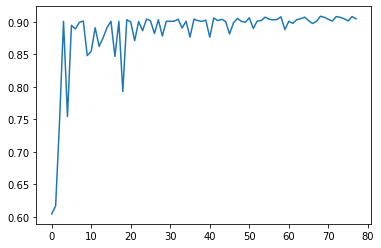

In [66]:
# validation accuracy 
plt.plot(range(len(val_accuracies)), val_accuracies)

In [67]:
val_losses

[513.8243289138331,
 239.2241045778448,
 7.87320487517299,
 7.884800625569893,
 7.77875176523671,
 6.958518161918178,
 7.203244874874751,
 6.907178750995434,
 6.544903408397328,
 7.168701153812987,
 6.915443541425647,
 6.142354079268196,
 6.4864706103548855,
 6.0913577156536505,
 5.587288907531536,
 5.166096997983528,
 6.1237413056872105,
 5.00393935676777,
 7.201590822953166,
 4.611877617059332,
 4.542916413509484,
 4.917605927496245,
 4.3061747801574795,
 4.483926377513192,
 3.899641291661696,
 3.8266611297925315,
 4.210702928629789,
 3.664009892353506,
 4.1904940169417495,
 3.546324536430113,
 3.4666808024048805,
 3.418643539376331,
 3.2900912445602994,
 3.59812762475375,
 3.3773375311584184,
 3.8201891468329863,
 3.2020073449521353,
 3.22116702546676,
 3.2263334513162123,
 3.1248615885322746,
 3.686803461927356,
 3.040372182699767,
 3.14624214465871,
 3.001577503979206,
 3.8157112300395966,
 3.5319395781014906,
 3.06636912262801,
 2.919065372736165,
 3.3142308601827333,
 3.00841084

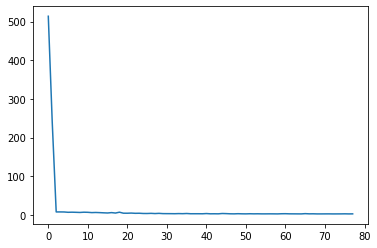

In [68]:
# validation loss 
plt.plot(range(len(val_losses)), val_losses)

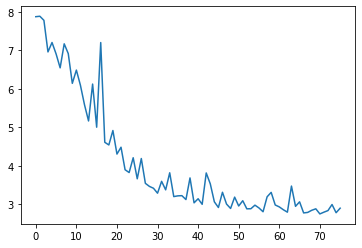

In [69]:
# validation loss 
plt.plot(range(len(val_losses[2:])), val_losses[2:])

In [76]:
model.eval()

WrapperModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

In [77]:
for j, (x,y) in enumerate(val_dataloader):
    y_pred_eval = model(x)
    break
    
compute_accuracy(y_pred_eval, y)

(0.8978365384615384, 0.04597701149425287, 0.06936895104084585)

In [78]:
y

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        

In [79]:
(y_pred_eval >= 0.5).type(torch.FloatTensor)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        

In [80]:
# evaluate_on(model, train_dataloader, 'train')

In [81]:
((y_pred_eval >= 0.4)*y).sum()/y.sum()

tensor(0.1149, device='cuda:0')

In [92]:
for j, (x,y) in enumerate(train_dataloader):
    y_pred_eval = model(x)
    break
    
compute_accuracy(y_pred_eval, y, 0.2)

(0.9146634615384616, 0.4868421052631579, 0.7560949961206521)

In [83]:
((y_pred_eval >= 0.4)*y).sum()/y.sum()

tensor(0.1194, device='cuda:0')

In [93]:
y

tensor([[1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1.],
        

In [94]:
(y_pred_eval >= 0.2).type(torch.FloatTensor)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        